# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

===========================================================================================================
## Idea!

I will try to approach the problem from two difference standpoints. First, I'll try to learn a target (regression or classification), and second, I'll analyze time-series as a whole for [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection). 


After manipulating the date (including removing noises, cutting the tail after failure, and assembling all machines data) and doing exploratory data analysis (EDA), I use the cleaned data to  observe normal, faulty, and use models to predict Time To Failure (TTF, regression), and possibility of failure within a time frame (binary classification/multiclass classification). Before doing a training, I start by a relatively simple approach in which I track the variation of standard deviation (std) by time. Given the fact that std increases (the amount of changes) during faulty mode, it could give us a hint of possibility of failure in future.  Later, for regression, I use Ridge regression, Random Forest, and Neural Network methods. Similarly for classification (I just show multiclass since binary would be a simpler version of multiclass),  I use Logistic regression and Random Forest. 


Later, for anomaly detection, I start by a relatively simple model (OneClassSVM) to pinpoint outliers for each machine time-series data. Next, I used LSTM to detect anomalies (inspired from [here](https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/)). However, I'm not going to show the LSTM results due to unsatisfactory performance. More tweaking/data and a better feature engineering may be needed. 

## Table of Contents
* [0 - Importing Libraries](#importing_libraries)
* [1 - Data Manipulation](#section1)
    * [1 - 1 - Denoising](#section_1_1)
    * [1 - 2 - Data Assembly](#section_1_2)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [2 - Exploratory Data Analysis (EDA)](#section2)
    * [2 - 1 - Section 2.1](#section_2_1)
    * [2 - 2 - Section 2.2](#section_2_2)
* [3 - Analysis](#section3)   
    * [3 - 1 - Variation of Standard Deviation](#section_3_1)
    * [3 - 2 -  Regression](#section_3_2)
        * [3 - 2 - 1 - Regression - Ridge](#section_3_2_1)
        * [3 - 2 - 2 - Regression - Random Forest](#section_3_2_2)
        * [3 - 2 - 3 - Regression - Neural Network](#section_3_2_3)
        
    * [3 - 3 -  Classification](#section_3_3)
        * [3 - 3 - 1 - Classification - Logistic Regression](#section_3_3_1)
        * [3 - 3 - 2 - Classification - Random Forest](#section_3_3_2)
    * [3 - 4 -  Anomaly Detection](#section_3_4)
        * [3 - 4 - 1 - Anomaly Detection - OneClassSVM](#section_3_4_1)
* [Conclusion](#Conclusion)   
* [References](#References)   

#### 0 - Importing Libraries <a class="anchor" id="importing_libraries"></a>


In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sn
import plotly.graph_objects as go
from sklearn.decomposition import PCA 
from scipy import stats
from sklearn.svm import OneClassSVM
from pandas.plotting import scatter_matrix
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import torch
from torch.nn import Linear
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import SGD, Adam, RMSprop
from torch.autograd import Variable, grad
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import math

%matplotlib inline 

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1 - Data Manipulation <a class="anchor" id="section1"></a>

I'll start from machine 0 but finally will combine time-series from all machines for learning purpose. 

#### Machine 0
I'm showing this machine as an example. Similar procedure may be followed for other machines by just changing the input file name.

In [2]:
df = pd.read_csv('exampleco_data/machine_0.csv')
col_names = ['dateTime','feature1','feature2','feature3','feature4']
df.columns = col_names
df['cycle'] = df.index + 1 # I will use this later for time to failure (TTF) estimation 
df['ID'] = 0*df['cycle'] # + ID # add machine id to to ID, from 0 to 19
df.head()

dateTime   feature1  feature2   feature3   feature4  \
0  2019-01-01 00:00:00.000000000  12.626096  8.803120 -11.809200  10.083961   
1  2019-01-01 08:00:09.603201067  10.831994  2.816327  11.554778  21.892853   
2  2019-01-01 16:00:19.206402134  21.083510 -0.672645 -17.839178  -1.349024   
3  2019-01-02 00:00:28.809603201  32.294495  6.525132 -13.498586  -4.250752   
4  2019-01-02 08:00:38.412804268  28.057100  3.691359  21.984744  13.670561   

   cycle  ID  
0      1   0  
1      2   0  
2      3   0  
3      4   0  
4      5   0

In [3]:
df.describe()

feature1     feature2     feature3     feature4        cycle      ID
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000  3000.0
mean     -0.816016    -1.091308     1.267945     0.165844  1500.500000     0.0
std      58.078319    55.965665    56.538700    56.910659   866.169729     0.0
min    -323.954437  -258.780879  -287.153920  -365.362164     1.000000     0.0
25%      -0.008684    -0.008851    -0.008274    -0.007883   750.750000     0.0
50%      -0.000402    -0.000085     0.000669     0.000310  1500.500000     0.0
75%       0.007832     0.008373     0.009056     0.008685  2250.250000     0.0
max     315.738951   264.374782   281.684102   340.513819  3000.000000     0.0

3000 data points in total! The statistics of each column is shown! Max and min values correspond to noises (will be discussed later), and a huge portion of data points are very close to zero (after failure). 'ID' changes for each machine. 

In [4]:
df.dtypes # all data is numeric + date 

dateTime     object
feature1    float64
feature2    float64
feature3    float64
feature4    float64
cycle         int64
ID            int64
dtype: object

In [5]:
df.isnull().sum() # no NaN values - clean dataset

dateTime    0
feature1    0
feature2    0
feature3    0
feature4    0
cycle       0
ID          0
dtype: int64

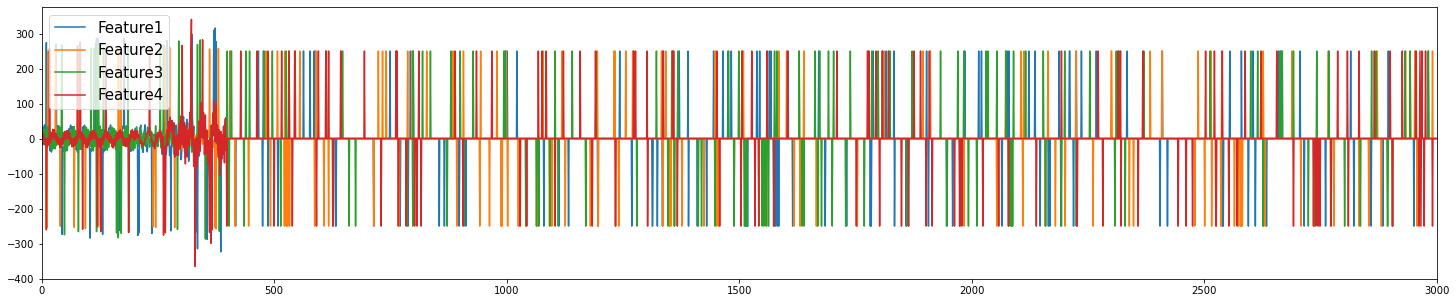

In [6]:
# plotting time-series for machine 0
plt.figure(figsize = (25, 5)) 
plt.plot(range(len(df)), df[['feature1', 'feature2', 'feature3', 'feature4']])
axes = plt.gca()
axes.legend(('Feature1','Feature2','Feature3', 'Feature4'), loc=0, fontsize=15)
axes.set_xlim([0, len(df)])
plt.show()

Noise is obvious in the data and the aforementioned three modes (normal, faulty, failure) are not clearly visible.

### 1 - 1 - Denoising <a class="anchor" id="section_1_1"></a>

In [7]:
def remove_outliers(df, m = 3):
    '''
    Removing noises by keeping all the rows with values within +-m standard deviation
    (m, can change when desired) of the mean for each column. 
    
    Args:
        df (dataframe): data in the form of pandas dataframe
        m (float): range of standard deviation, default is m = 3
    
    Returns:
        df: updated df after denoising
    '''
    for i in range(4):
        df = df[(df['feature'+str(i+1)] >= df['feature'+str(i+1)].mean() - m*df['feature'+str(i+1)].std()) & (df['feature'+str(i+1)] <= df['feature'+str(i+1)].mean() + 
                                                                    m*df['feature'+str(i+1)].std())]
    return df

In [8]:
df = remove_outliers(df, 3) # removing outlier

This figure shows the effect of denoising - Now three stages are clear, normal, then faulty, and finally failure. 

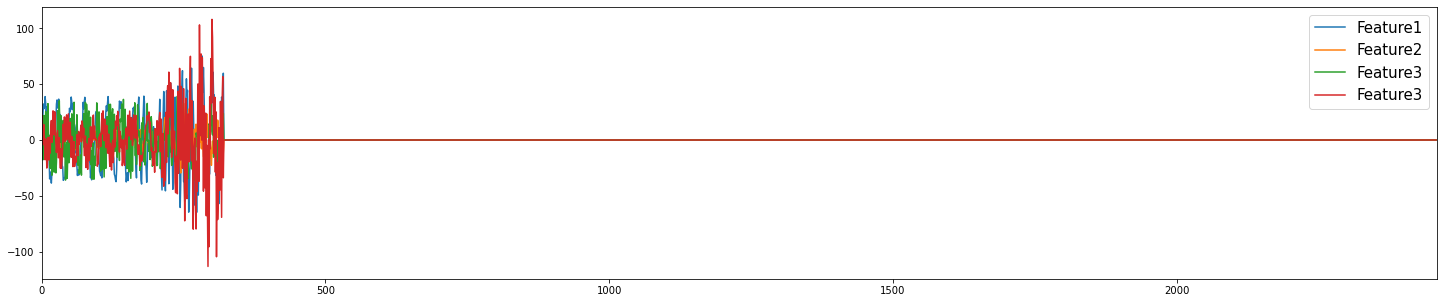

In [9]:
# plotting clean data
plt.figure(figsize = (25, 5)) 
plt.plot(range(len(df)), df[['feature1', 'feature2', 'feature3', 'feature4']])
axes = plt.gca()
axes.legend(('Feature1','Feature2','Feature3','Feature3'), loc=0, fontsize=15)
axes.set_xlim([0, len(df)])
plt.show()

This denoising approach seems to work for all machines. Something to notice is that after failure, the data is very close to zero and having them for whatever length will not add any value in our prediction of failure. They're basically post-failure information that would not be very helpful for predictive maintenance. Therefore, at this point, I get rid of the tail of time-series for each machine, and combine the data for all machine and proceed with the analysis in next sections. In order to perform this, I'll add two extra columns per each feature column to include rolling mean and standard deviation. 

In [10]:
def add_features(df_in, rolling_win_size, time_period):
    
    '''
    Add rolling average and rolling standard deviation for sensors readings using fixed rolling window size.
    
    Args:
            df_in (dataframe)     : The input dataframe to be proccessed (training or test) 
            rolling_win_size (int): The window size, number of cycles for applying the rolling function
            time_period (int): The time period, number of cycles for multiclass classification
            
    Reurns:
            dataframe: contains the input dataframe with additional rolling mean and std for each sensor
    '''
    
    max_cycle = df_in['cycle'].values[-1]
    
    sensor_cols = ['feature1','feature2','feature3', 'feature4']
    
    sensor_av_cols = [nm.replace('feature', 'avg') for nm in sensor_cols]
    sensor_sd_cols = [nm.replace('feature', 'std') for nm in sensor_cols]
    
    df_out = pd.DataFrame()
    
    ws = rolling_win_size
       
    # get a subset for each engine sensors
    df_sub = df_in[sensor_cols]

    
    # get rolling mean for the subset
    av = df_sub.rolling(ws, min_periods=1).mean()
    av.columns = sensor_av_cols
    
    # get the rolling standard deviation for the subset
    sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
    sd.columns = sensor_sd_cols
    
    # combine the two new subset dataframes columns to the engine subset
    new_ftrs = pd.concat([df_in,av,sd], axis=1)
    
    # add the new features rows to the output dataframe
    df_out = pd.concat([df_out,new_ftrs])
        
    # add labels for time to failure estimation and binary classification 
    df_out['TTF'] = max_cycle - df_out['cycle'] # adding TFF target values
    # For Binary, being less than a parameter time_period means 1 (failure happens soon), 0 otherwise
    df_out['Binary'] = df_out['TTF'].apply(lambda x: 1 if x <= time_period else 0) # Adding binary classification
    # For MultiClass, being less than a parameter time_period/2 means 2 (failure happens soon), 1 if it's less than time_period, and 0 otherwise
    df_out['MultiClass'] = df_out['TTF'].apply(lambda x: 2 if x <= time_period/2 else 1 if x <= time_period else 0) # Adding multiclass target values
    
    return df_out

In [11]:
def remove_tail(df, threshold = 0.1):
    '''
    Removing the tail of the the time-series for each machine by starting from the tail
    and drop every row  with a below threshold std (I'm using std1 and it seems to work). It stops when
    it reaches a high enough value
    
    Args:
        df (dataframe): The input dataframe to be proccessed (training or test) 
        threshold (float): Threshold for failure mode response
    
    Returns:
        df (dataframe): Updated time-series
    '''
    std = 0
    k = 1
    while std < threshold:
        std = abs(np.array(df.tail(k)['feature1'])[0])
        k += 1
    df.drop(df.tail(k - 3).index,inplace=True) # drop last n rows. This keeps the first value after failure - Check out the figure below  
    return df

In [12]:
df_cut = remove_tail(df, 0.1) # getting rid of tail of time-series after failure
df_cut = df_cut.reset_index(drop=True) # reseting indices 

In [13]:
# after denoising and cutting the tail of time-series - Last data point of each time-series is the failure index
# Use the scrolling bar to zoom in and inspect different parts of data
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_cut.index, y=df_cut['feature1'], name="Feature 1",line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=df_cut.index, y=df_cut['feature2'], name="Feature 2",line_color='dimgray'))
fig.add_trace(go.Scatter(x=df_cut.index, y=df_cut['feature3'], name="Feature 3",line_color='indianred'))
fig.add_trace(go.Scatter(x=df_cut.index, y=df_cut['feature4'], name="Feature 4",line_color='seagreen'))
fig.update_layout(title_text='Sensor Data',xaxis_rangeslider_visible=True)
fig.show()

Adding rolling mean and standard deviation features

In [14]:
time_period = 20 # Seems that 20 be a good estimate of period - Inspecting some time-series visually
df_w_feature = add_features(df_cut, 10, time_period) # Adding rolling mean and std
df_w_feature.head()

dateTime   feature1  feature2   feature3   feature4  \
0  2019-01-01 00:00:00.000000000  12.626096  8.803120 -11.809200  10.083961   
1  2019-01-01 08:00:09.603201067  10.831994  2.816327  11.554778  21.892853   
2  2019-01-01 16:00:19.206402134  21.083510 -0.672645 -17.839178  -1.349024   
3  2019-01-02 00:00:28.809603201  32.294495  6.525132 -13.498586  -4.250752   
4  2019-01-02 08:00:38.412804268  28.057100  3.691359  21.984744  13.670561   

   cycle  ID       avg1      avg2       avg3       avg4      std1      std2  \
0      1   0  12.626096  8.803120 -11.809200  10.083961  0.000000  0.000000   
1      2   0  11.729045  5.809723  -0.127211  15.988407  1.268622  4.233302   
2      3   0  14.847200  3.648934  -6.031200  10.209263  5.474794  4.792437   
3      4   0  19.209024  4.367983  -7.898047   6.594260  9.802258  4.168904   
4      5   0  20.978639  4.232658  -1.921488   8.009520  9.365943  3.623036   

        std3       std4  TTF  Binary  MultiClass  
0   0.000000   0.000000  397       0           0  
1  16.520827   8.350147  396       0           0  
2  15.525467  11.621445  395       0           0  
3  13.214911  11.929445  394       0           0  
4  17.594648  10.805025  393       0           0

### 1 - 2 - Data Assembly <a class="anchor" id="section_1_2"></a>
Here, I'm going to repeat the same processes for each machine and combine time-series to be used for learning.

In [15]:
def data_assembly(time_period):
    '''
    Performing all the above methods on each machine data and return the assembled dataframe.
    
    Args:
        time_period (int): Time period for classification purpose.  
        
    Returns:
        df_total (dataframe): the assembled dataframe after denoising, cutting the tail, and adding new features
    '''
    df_total = pd.DataFrame()
    for i in range(20):
        df = pd.read_csv('exampleco_data/machine_'+str(i)+'.csv')
        col_names = ['dateTime','feature1','feature2','feature3','feature4']
        df.columns = col_names
        df['cycle'] = df.index + 1 # I will use this later for time to failure estimation 
        df['ID'] = 0*df['cycle'] + i # adding machine id
        
        df = remove_outliers(df, 3) # removing outlier
        
        df_cut = remove_tail(df, 0.1)
        
        df_w_feature = add_features(df_cut, 10, time_period)
        del df_w_feature['dateTime']
        df_total = pd.concat([df_total, df_w_feature])

    return df_total

In [16]:
df_train_test = data_assembly(time_period) # Assembling all time-series
# df_train_test.to_csv('training.csv', index=False)

In [17]:
df_train_test.tail()

feature1   feature2   feature3   feature4  cycle  ID       avg1  \
47  47.859159 -23.291756 -45.349960 -51.564022     48  19  17.762351   
48  26.021192  -7.767045 -27.644914   2.925497     49  19  23.271515   
49  -6.512546  -8.117634 -21.287382   7.608549     50  19  25.566661   
50   4.804001 -15.390912 -14.643192 -85.000097     51  19  28.978821   
51  -0.005761   0.005138   0.012038   0.023510     52  19  27.946019   

        avg2       avg3      avg4       std1       std2       std3       std4  \
47  3.226310  -2.369915  5.156280  38.136960  22.205825  26.533240  44.491953   
48 -1.467251  -7.606228  8.256705  34.417757  18.398673  25.748753  42.972972   
49 -5.131196 -13.487227  5.411915  31.117370  15.118932  20.471349  41.855244   
50 -7.815039 -16.377599 -6.925780  25.856428  14.203353  18.010926  48.685169   
51 -8.664543 -16.617821 -3.971865  26.870814  13.347365  17.746518  48.054305   

    TTF  Binary  MultiClass  
47    4       1           2  
48    3       1           2  
49    2       1           2  
50    1       1           2  
51    0       1           2

In [18]:
df_train_test.describe()

feature1      feature2      feature3      feature4         cycle  \
count  11464.000000  11464.000000  11464.000000  11464.000000  11464.000000   
mean       0.116371      0.044779      0.020567     -0.179688    575.649337   
std       26.741472      7.035855     18.578712     20.838066    479.937568   
min      -78.369802    -42.185373    -54.242504   -116.809275      1.000000   
25%      -23.740557     -3.654464    -13.653036    -11.223025    196.000000   
50%        0.171577     -0.010556      0.003430     -0.000652    428.000000   
75%       24.059068      3.703323     13.580232     11.448679    856.000000   
max       80.057881     44.112802     47.545806    119.840554   1881.000000   

                 ID          avg1          avg2          avg3          avg4  \
count  11464.000000  11464.000000  11464.000000  11464.000000  11464.000000   
mean       8.494330      0.240322      0.076176     -0.038481     -0.158890   
std        5.732801     17.183560      3.086650      8.394968     10.063350   
min        0.000000    -47.568769    -19.601459    -27.504592    -85.774575   
25%        2.000000    -14.756206     -1.954788     -7.035739     -7.051359   
50%        8.000000      0.295710      0.012459     -0.224165     -0.110446   
75%       15.000000     15.382450      1.989401      6.940975      6.969984   
max       19.000000     46.503663     23.760577     26.867842     46.613089   

               std1          std2          std3          std4           TTF  \
count  11464.000000  11464.000000  11464.000000  11464.000000  11464.000000   
mean      19.691648      5.474445     17.265017     15.853032    570.742673   
std        8.441359      3.616611      2.512604     10.362903    477.944295   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       13.529187      3.779338     15.766566     10.908934    192.750000   
50%       19.143479      4.222980     17.166989     12.325485    421.000000   
75%       23.265598      4.774849     18.744196     14.104170    848.000000   
max       55.454144     30.727294     33.191888     76.500394   1880.000000   

             Binary    MultiClass  
count  11464.000000  11464.000000  
mean       0.030792      0.046581  
std        0.172761      0.275671  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      2.000000

# 2 - Exploratory Data Analysis (EDA) <a class="anchor" id="section2"></a>

Below shows a descending list of standard deviation for feature. If the features list were very long, we could do a PCA analysis to keep important features. As expected, std shows a higher variation and will probably be more affective on the target value. 

In [19]:
print(df_train_test[['feature1', 'feature2', 'feature3', 'feature4', 
                        'avg1', 'avg2', 'avg3', 'avg4', 'std1', 'std2', 'std3', 
                        'std4']].std().sort_values(ascending=False))

feature1    26.741472
feature4    20.838066
feature3    18.578712
avg1        17.183560
std4        10.362903
avg4        10.063350
std1         8.441359
avg3         8.394968
feature2     7.035855
std2         3.616611
avg2         3.086650
std3         2.512604
dtype: float64


Below shows the correlation of each feature to TTF in descending order. 

In [20]:
df_train_test[['feature1', 'feature2', 'feature3', 'feature4', 
                        'avg1', 'avg2', 'avg3', 'avg4', 'std1', 'std2', 'std3', 
                        'std4']].corrwith(df_train_test['TTF']).sort_values(ascending=False)

avg4        0.033358
avg3        0.021529
avg1        0.017007
feature4    0.012593
feature1    0.009043
feature3    0.008556
std3        0.007654
feature2   -0.005093
avg2       -0.005883
std1       -0.336552
std4       -0.397537
std2       -0.408430
dtype: float64

As was shown above and can be seen in the heatmap below, standard deviations are the ones with the highest correlation with the TTF (as expected). One simple and seems to be somehow effective approach (at least in the current problem) is to track standard deviation of sensor, and once they're above a treshold, we can predict that failure will happen in the future (we entered faulty mode) and maintenance is necessary. I'll talk about this later.

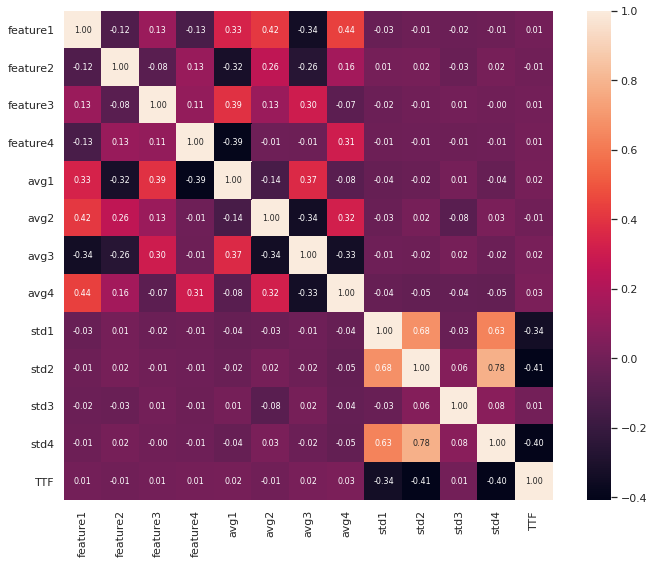

In [21]:
fig = plt.figure(figsize=(12, 9))
corrMatrix = df_train_test[['feature1', 'feature2', 'feature3', 'feature4', 
                        'avg1', 'avg2', 'avg3', 'avg4', 'std1', 'std2', 'std3', 
                        'std4', 'TTF']].corr()
sn.set(font_scale=1.0)
sn.heatmap(corrMatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8})
plt.show()
# print(df_train_test.corr())

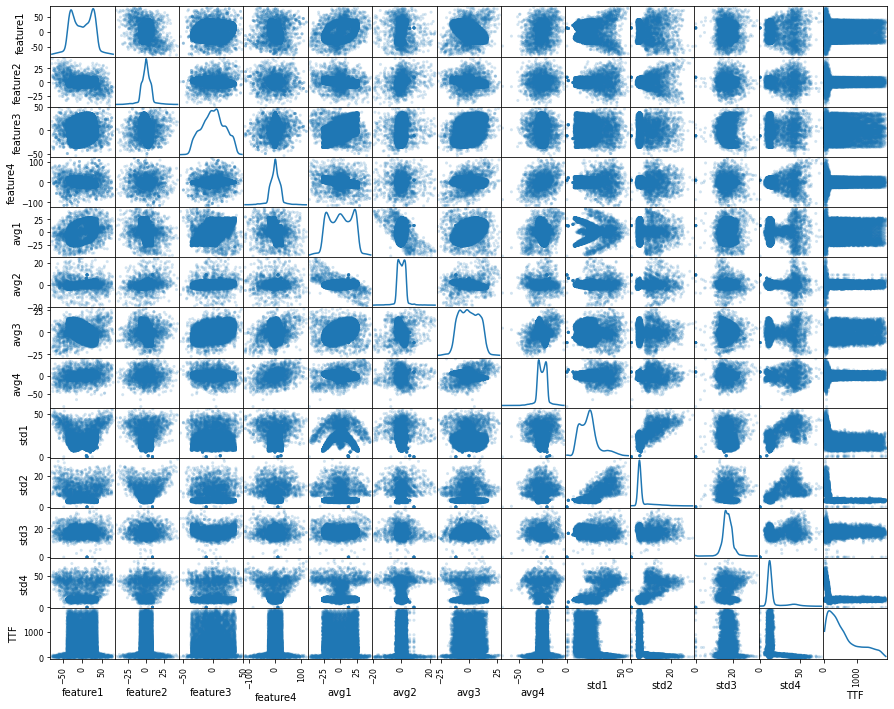

In [22]:
sn.reset_orig()
scatter_matrix(df_train_test[['feature1', 'feature2', 'feature3', 'feature4', 
                        'avg1', 'avg2', 'avg3', 'avg4', 'std1', 'std2', 'std3', 
                        'std4', 'TTF']], alpha=0.2, figsize=(15, 12), diagonal='kde')
plt.show()

Some features show close to Gaussian distribution (will be helpful for learning). Also, most of the features have a nonlinear relationship with TTF. 

In [23]:
# Create a function to explore the time series plot each sensor selecting random sample engines
def plot_time_series(df_train_test, s):
    
    """
    Plotting time series of a single sensor for 3 random sample machines.
    
    Args:
        s (str): The column name of the sensor to be plotted.

    Returns: 
        plots
    """
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize = (15, 5))
    fig.suptitle(s + ' time series ', fontsize=15)
    
#     np.random.seed(12345) # for reproducibility of data in case necessary
    select_engines = np.random.choice(range(1,21), 3, replace=False).tolist() # choose 3 machines randomly

    for e_id in select_engines:
        df_new = df_train_test[df_train_test['ID'] == e_id]
        df_new = df_new[['cycle', s]]
        i = select_engines.index(e_id)
        axes[i].plot(df_new['cycle'],df_new[s])
        axes[i].set_ylabel('machine ' + str(e_id))
        axes[i].set_xlabel('cycle')
        axes[i].set_xlim([0, 2000])


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

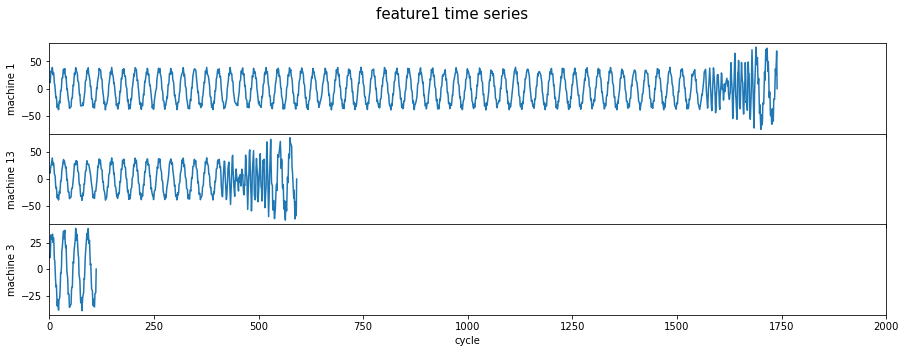

In [24]:
plot_time_series(df_train_test, 'feature1') # This can be done for other features

An unbalaced dataset is shown below for classification. Therefore, we are going to use AUC ROC in the future analysis. 

In [25]:
print(df_train_test['MultiClass'].value_counts())
print('\n 0 samples =  {0:.0%}'.format(df_train_test['MultiClass'].value_counts()[0]/df_train_test['MultiClass'].count()))
print('\n 1 samples =  {0:.0%}'.format(df_train_test['MultiClass'].value_counts()[1]/df_train_test['MultiClass'].count()))
print('\n 2 samples =  {0:.0%}'.format(df_train_test['MultiClass'].value_counts()[2]/df_train_test['MultiClass'].count()))

0    11111
2      181
1      172
Name: MultiClass, dtype: int64

 0 samples =  97%

 1 samples =  2%

 2 samples =  2%


#### EDA observation

* There are different levels of correlation between features and TTF. Some show a higher correlation.
* Standard deviation shows the highest correlation with TTF. 
* Features show nonlinear correlation with respect to target (TTF). 
* The dataset shows an unbalanced distribution of target for binary classification. I'll use Area Under the Curve (AUC) ROC for evaluation. 

# 3 - Analysis <a class="anchor" id="section3"></a>

For the analysis, I follow two general approaches: 1) Try to do a regression to estimate TTF and 2) Do a multiclass classification. The later would be helpful for a smarter maintenance. Here, I'm using three classses including more than 20 cycles to failure, between 10 and 20 cycles to failure, and less than 10 cycles to failure (the numbers can change). For regression, I use Ridge, Random Forest, and Neural Network. For classification, I'll use Logistic Regression, and Random Forest. I'm not using NN for classification due to the acceptable performance of two methods. Moreover, the approach is pretty similar to the one in Regression session. 

I first try to predict failure by using a standard deviation as a way of predicting whether failure would happen soon by using faulty state data. For each machine, the model tries to find whether the standard deviation is above a certain level, and retun whether failure is going to occur soon. Note that such a model is not able to predict how long it takes for a machine to fail. A second sudden change should be implemented to predict failure cycle number, and the subtraction of two will give the number of cycles from the start of faulty mode to failure. 

## 3 - 1 - Variation of Standard Deviation <a class="anchor" id="section_3_1"></a>

Here, I try to find a sudden change with respect to a previous windows of data using a threshold above which the change would be called "sudden change", which is an indicator of start of faulty model. However, it doesn't always work as shown below for machine 0. If we use feature 1, it can somehow accurately predict the start of faulty mode. But, using feature 3 results in no sudden change in the standard deviation (doesn't return anything). Therefore, it's not gauranteed that this method would pick the start of faulty mode. I've observed that including all features for each machine could result in a decent prediction of start of faulty mode. An extension of this approach could be to include the point of failure (the significant drop after faulty mode) using standard deviation and mean so that one could be able to predict time to failure (TTF) from this analysis. 

In [26]:
def pick_sudden_change(df, window, threshold, col_name):
    '''
    Picking row id with sudden standard deviation change
    
    Args:
        df (dataframe): Date for a specific machine
        window (int): The rolling window size
        Threshold (float): The threshold for jump in standard deviation
        col_name (str): The column for which sudden jump is standard deviation is studied
        
    Returns:
        prints the id at which the sudden jump starts
    '''
    roll_std = df.rolling(window = window).std() 
    previous_win_std = np.std(roll_std[window:window * 2][col_name])
    
    for i in range(window * 2, len(roll_std), window):   
        current_win_std = roll_std[i:i+window][col_name].std()    
        if(current_win_std > (threshold * previous_win_std)):
            sudden_change_pt = i
            print('Sudden Change Point: ', sudden_change_pt)
            plt.figure(figsize = (10, 3))
            # plotting standard deviation rolling windows after sudden jump
            roll_std[sudden_change_pt:][col_name].plot(color = 'red', label = 'Rolling standard deviation')
            df[col_name].plot(color = 'blue')
            plt.title('Plot of Time Series For Feature '+col_name[-1])
            plt.legend()
            break
        else:
            previous_win_std = current_win_std
            sudden_change_pt = i

Sudden Change Point:  200


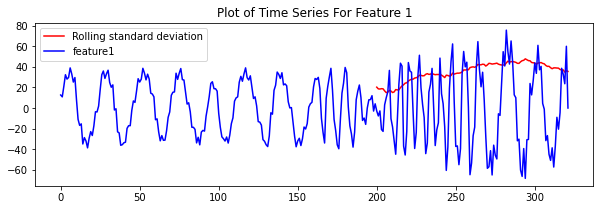

In [27]:
df = pd.read_csv('exampleco_data/machine_0.csv')
col_names = ['dateTime','feature1','feature2','feature3','feature4']
df.columns = col_names
df['cycle'] = df.index + 1 # I will use this later for time to failure (TTF) estimation 
df['ID'] = 0*df['cycle'] # adding machine id

df = remove_outliers(df, 3) # removing outlier
df = remove_tail(df, 0.1) # cut the unnecessary tail of time-series using the method mentioned before
df = df.reset_index(drop=True)
time_period = 25
window = 25 # somehow arbitrary number, 25 seems to be a good estimate of period of time-series of machine 0
threshold = 3

col_name = 'feature1'
pick_sudden_change(df, window, threshold, col_name) # return row 200 as a starting point of faulty mode
col_name = 'feature3'
pick_sudden_change(df, window, threshold, col_name) # doesn't return anything

## 3 - 2 - Regression  <a class="anchor" id="section_3_2"></a>

Since the sudden change in the standard variation does not always work for detection of faulty modes, I'm going to do a series of analysis to calculate the desired output to prevent excessive maintenace and predict the possibility of failure in near future (in terms of number of cycles). Regression analysis is performed in this section. 

In [28]:
# Splitting dataset to test and train
train_data, test_data = train_test_split(df_train_test, test_size=0.1, shuffle = True) # I didn't fix the seed number. 
# 10% of data is used for test. 

print('Training data shape is:', train_data.shape,', Testing data shape is:', test_data.shape)
features = ['feature1', 'feature2', 'feature3', 'feature4', 'avg1', 'avg2', 'avg3', 'avg4', 'std1',
           'std2', 'std3', 'std4', 'ID'] # features to be used for regression

X_train = train_data[features]
y_train = train_data['TTF']

X_test = test_data[features]
y_test = test_data['TTF']

Training data shape is: (10317, 17) , Testing data shape is: (1147, 17)


In [29]:
def get_regression_metrics(model, actual, predicted):
    
    """
    Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted)
                   }

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [30]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    
    """
    Plotting regression coefficients weights or feature importance.
    
    Args:
        model (str): The model name identifier
        weights (array): Contains the regression coefficients weights or feature importance
        feature_names (list): Contains the corresponding features names
        weights_type (str): 'c' for 'coefficients weights', otherwise is 'feature importance'
        
    Returns:
        plot of either regression coefficients weights or feature importance
    """
    (px, py) = (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

### 3 - 2 - 1 - Regression - Ridge <a class="anchor" id="section_3_2_1"></a>

In [31]:
rdg = linear_model.Ridge(alpha=0.005)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.234, R^2 test: 0.199


Ridge Regression
Root Mean Squared Error        434.410843
Mean Absolute Error            345.427190
R^2                              0.198940

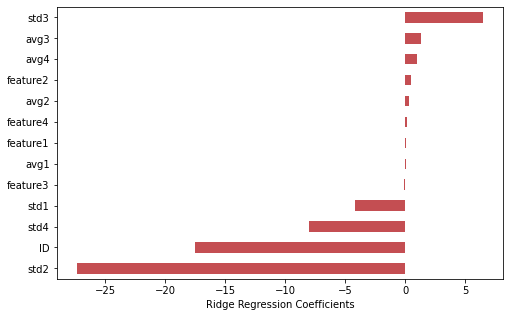

In [32]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

Ridge regression does not return a satisfactory result due to its simplicity and nonlinear nature of features-TTF relation.

### 3 - 2 - 2 - Regression - Random Forest<a class="anchor" id="section_3_2_2"></a>

In [33]:
rf = RandomForestRegressor(n_estimators=300, max_features=6, max_depth=8, n_jobs=-1, random_state=1) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

# rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
# rf_metrics

R^2 training: 0.548, R^2 test: 0.515


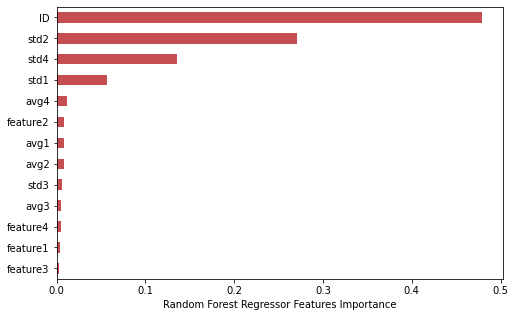

In [34]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

Random Forest performs better than Ridge. The ensemble nature of Random Forest also helps with overfitting problem. 

### 3 - 2 - 3 - Regression - Neural Network<a class="anchor" id="section_3_2_3"></a>

I've not written this class in the past few days, it comes from another project for time-series prediction I worked on. It uses ResNet block in the network architecture, l2 as loss function, and Adam/SGD optimization algorithm. 

In [35]:
class Reg_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the neural network - 
        self.relu = torch.nn.ReLU()
        
        # Layers 
        self.fc0  = Linear(13,13)
        self.fc1  = Linear(13,13)

        # resnet - block 1
        self.rn1_fc1  = Linear(13,13)
        self.rn1_fc2  = Linear(13,13)
        self.rn1_fc3  = Linear(13,13)

        # resnet - block 2 
        self.rn2_fc1  = Linear(13,26*3)
        self.rn2_fc2  = Linear(13,26*3)
        self.rn2_fc3  = Linear(26*3,26*3)

        # resnet - block 3
        self.rn3_fc1  = Linear(26*3,26*3)
        self.rn3_fc2  = Linear(26*3,26*3)
        self.rn3_fc3  = Linear(26*3,26*3)
        
#         # resnet - block 4
        self.rn4_fc1  = Linear(26*3,26*3)
        self.rn4_fc2  = Linear(26*3,13)
        self.rn4_fc3  = Linear(26*3,13)
        
        # Output structure
        self.fc8  = Linear(13,13)
        self.fc9  = Linear(13,1)

    def forward(self, x):
        
        x   = self.relu(self.fc0(x))
        x   = self.relu(self.fc1(x))

        # Resnet - Block 1
        x0  = x
        x   = self.relu(self.rn1_fc1(x))
        x   = self.relu(self.rn1_fc3(x) + self.rn1_fc2(x0))


        # Resnet - Block 2
        x0  = x
        x   = self.relu(self.rn2_fc1(x))
        x   = self.relu(self.rn2_fc3(x)+self.rn2_fc2(x0))

        # Resnet - Block 3
        x0  = x
        x   = self.relu(self.rn3_fc1(x))
        x   = self.relu(self.rn3_fc3(x)+self.rn3_fc2(x0))
        
        # Resnet - Block 4
        x0  = x
        x   = self.relu(self.rn4_fc1(x))
        x   = self.relu(self.rn4_fc3(x)+self.rn4_fc2(x0))


        # Joining two blocks
        x     = self.relu(self.fc8(x))
        x   = self.fc9(x)

        return x

In [36]:
class NumpyDataset(torch.utils.data.Dataset):

    def __init__(self, data, target, transform=None):
        # Creating identical pairs
        self.data    = Variable(Tensor(data))
        self.target  = Variable(Tensor(target))

    def send_device(self,device):
        self.data    = self.data.to(device)
        self.target  = self.target.to(device)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y, index

    def __len__(self):
        return self.data.shape[0]

def init_weights(m):
    if type(m) == torch.nn.Linear:
        stdv = (1. / math.sqrt(m.weight.size(1))/1.)*2
        m.weight.data.uniform_(-stdv,stdv)
        m.bias.data.uniform_(-stdv,stdv)

def EikonalLoss(Yobs,Ypred):

        loss_2 = loss_funcl2(Ypred, Yobs)
        loss_1 = loss_funcl1(Ypred, Yobs)
    
        return loss_2

In [37]:
class Model():
    def __init__(self, network, optimizer,scheduler, model_path, model_name):
        self.network    = network
        self.optimizer  = optimizer
        self.model_path = model_path
        self.model_name = model_name
        self.scheduler  = scheduler

        self.total_train_loss = []
        self.total_val_loss   = []
        
    def train(self, dataset,n_epochs):
        from torch.autograd import Variable
        import time

        len_dataset         = len(dataset)
        n_batches           = int(len(dataset)/btsize + 1)
        training_start_time = time.time()

        # Sending the data to CPU
        dataset.send_device(device) 

        # --------- Splitting the dataset into training and validation -------
        indices            = list(range(int(len_dataset)))
        validation_idx     = indices[:int(len_dataset*(validation_per/100))]  #np.random.choice(indices, size=int(len_dataset*(validation_per/100)), replace=False)
        train_idx          = list(set(indices) - set(validation_idx))
        validation_sampler = SubsetRandomSampler(validation_idx)
        train_sampler      = SubsetRandomSampler(train_idx)

        train_loader       = torch.utils.data.DataLoader(
            dataset,
            batch_size=btsize,
            sampler=train_sampler,
            )    
        validation_loader  = torch.utils.data.DataLoader(
            dataset,
            batch_size=btsize,
            sampler=validation_sampler,
        )    


        for epoch in range(n_epochs):
            print_every           = 1
            start_time            = time.time()
            running_sample_count  = 0

            total_train_loss      = 0
            total_val_loss        = 0


            for i, data in enumerate(train_loader, 0):
                #print('----------------- Epoch {} - Batch {} --------------------'.format(epoch,i))
                
                # Get inputs/outputs and wrap in variable object
                inputs, labels, indexbatch = data
                # Making sure input and labels are floats
                inputs.float()
                labels.float()
                
                # Setting so the inputs require a gradient
                inputs.requires_grad_()

                pred_labels = self.network(inputs)
                loss_ = EikonalLoss(labels,pred_labels)

    
    
                # Update parameters
                loss_.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            # ----- Determining the Training Loss -----
            for i, data_train in enumerate(train_loader, 0):
                inputs_train, labels_train, indexbatch_train = data_train
                inputs_train.requires_grad_()
#                 outputs_train,pred_labels_train = self.network(inputs_train)
                pred_labels_train = self.network(inputs_train)
                train_loss              = EikonalLoss(labels_train,pred_labels_train)
                total_train_loss           += train_loss.item()
#                 del inputs_train, labels_train, indexbatch_train, pred_labels_train, train_loss, wv


            # ----- Determining the Validation Loss -----
            for i, data_val in enumerate(validation_loader, 0):
                inputs_val, labels_val, indexbatch_val = data_val
                inputs_val.requires_grad_()
                pred_labels_val = self.network(inputs_val)
#                 outputs_val,pred_labels_val = self.network(inputs_val)
                val_loss                 = EikonalLoss(labels_val,pred_labels_val)
                total_val_loss             += val_loss.item()
#                 del inputs_val, labels_val, indexbatch_val, pred_labels_val, val_loss, wv




            # Creating a running loss for both training and validation data
            total_val_loss   /= len(validation_loader)
            total_train_loss /= len(train_loader)
            self.total_train_loss.append(total_train_loss)
            self.total_val_loss.append(total_val_loss)
            self.scheduler.step(total_val_loss)


            if (epoch+1) % 10 == 1:
                with torch.no_grad():
                    print("Epoch = {} -- Training loss = {:.4e} -- Validation loss = {:.4e}".format(epoch+1,total_train_loss,total_val_loss))

            if (epoch+1) % 100 == 1:
                with torch.no_grad():
                    torch.save({
                        'epoch':epoch,
                        'model_state_dict': self.network.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': self.total_train_loss,
                        'val_loss': self.total_val_loss,
                        }, '{}/{}_{}_{}.pt'.format(self.model_path, self.model_name,str(epoch).zfill(5),total_val_loss))

In [38]:
X_train_NN = train_data[features]
y_train_NN = train_data['TTF']

X_test_NN = test_data[features]
y_test_NN = test_data['TTF']

In [39]:
type(X_train_NN)

pandas.core.frame.DataFrame

In [40]:
num_epochs         = 101
validation_per     = 10
btsize             = 32

sc = StandardScaler()
X_train_NN = sc.fit_transform(X_train_NN)
X_test_NN = sc.transform(X_test_NN)

y_train_NN = np.array(y_train_NN).reshape((len(y_train_NN),1))
y_test_NN = np.array(y_test_NN).reshape((len(y_test_NN),1))

sc_y = StandardScaler()
y_train_NN = sc_y.fit_transform(y_train_NN)
y_test_NN = sc_y.transform(y_test_NN)


# -------------------------------------------------------------------
PATH                                 = './OutputModels'
# X_train_NN = preprocessing.scale(np.array(X_train_NN))
# y_train_NN = preprocessing.scale(np.array(y_train_NN))
# y_train_NN = y_train_NN.reshape((len(y_train_NN),1))


dataset                              = NumpyDataset(X_train_NN,y_train_NN)

# -------------------------------------------------------------------
# device             = torch.device("cuda:{}".format(GPUid))
device = torch.device("cpu")
torch.set_num_threads(5)

# --------- Defining the neural network -------
net = Reg_model()
net.apply(init_weights)
net.float()
net.to(device)
loss_funcl2 = torch.nn.MSELoss(reduction='mean')
loss_funcl1 = torch.nn.L1Loss(reduction='mean')

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', count_parameters(net))

print('Training input size:', np.array(X_train_NN).shape,'  Training target size:', np.array(y_train_NN).shape)

Number of parameters in network:  36154
Training input size: (10317, 13)   Training target size: (10317, 1)


In [41]:
# ## --------- Defining optimizer -------
# optimizer  = torch.optim.Adam(net.parameters(),lr=1e-3)
# # optimizer  = torch.optim.SGD(net.parameters(),lr=1e-3)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# # --------- Training Model -------
# model = Model(net, optimizer,scheduler,model_path=PATH,model_name='Tagup')
# model.train(dataset,num_epochs)

In [42]:
def load_checkpoint(filepath,device):
    '''
    Loading an instance of EikoNet from a saved .pt
    
    
    INPUTS:
        filepath - path to .pt file
            
    OUTPUTS:
        model - Eikonet Model
    '''
    
    
    checkpoint = torch.load(filepath)
    # Defining Neural Network
    net = Reg_model().to(device)
    net.apply(init_weights)
    net.float()
    net.to(device)
    optimizer  = torch.optim.Adam(net.parameters())
    scheduler = []
    model = Model(net, optimizer,scheduler, model_path=filepath,model_name='')
    model.total_train_loss = checkpoint['train_loss']
    model.total_val_loss   = checkpoint['val_loss']

    model.network.load_state_dict(checkpoint['model_state_dict'])
    for parameter in model.network.parameters():
        parameter.requires_grad = False

    model.network.eval()
    return model

In [43]:
fname = './OutputModels/Tagup_00100_0.4793926188440034.pt'
md    = load_checkpoint(fname,device)

In [44]:
test_tensor_x = torch.tensor(X_train_NN).float() # added .values when no scaling in preprocess
test_tensor_y = torch.tensor(y_train_NN).float() # added .values when no scaling in preprocess

bs = len(y_train_NN)

test_loaded = torch.utils.data.TensorDataset(test_tensor_x,test_tensor_y)

test_loader = torch.utils.data.DataLoader(test_loaded,batch_size=bs, shuffle=False)

with torch.no_grad():
    for batch_size_test, (data, target) in enumerate(test_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = md.network(data)
        break    

In [45]:
test_tensor_x = torch.tensor(np.array(X_test_NN)).float() # added .values when no scaling in preprocess
test_tensor_y = torch.tensor(np.array(y_test_NN)).float() # added .values when no scaling in preprocess

bs = len(y_test_NN)

test_loaded = torch.utils.data.TensorDataset(test_tensor_x,test_tensor_y)

test_loader = torch.utils.data.DataLoader(test_loaded,batch_size=bs, shuffle=False)

with torch.no_grad():
    for batch_size_test, (data, target) in enumerate(test_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output_test = md.network(data)
        break

In [46]:
print('R^2 training: %.3f, R^2 test: %.3f' % (
    (metrics.r2_score(y_train_NN, output.numpy())), 
    (metrics.r2_score(y_test_NN, output_test.numpy()))))

R^2 training: 0.590, R^2 test: 0.577


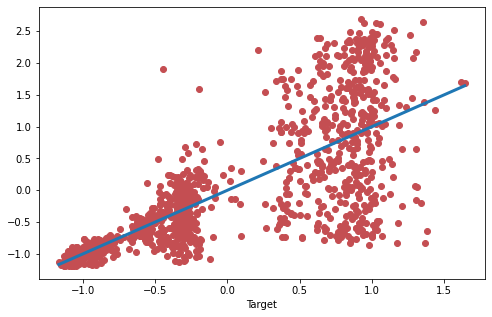

In [47]:
test_1_x = np.array(X_test_NN)
test_1_y = np.array(y_test_NN)

test_tensor_x = torch.tensor(test_1_x).float() # added .values when no scaling in preprocess
test_tensor_y = torch.tensor(test_1_y).float() # added .values when no scaling in preprocess

bs = test_1_y.shape[0]
test_loaded = torch.utils.data.TensorDataset(test_tensor_x,test_tensor_y)

test_loader = torch.utils.data.DataLoader(test_loaded,batch_size=bs, shuffle=False)

with torch.no_grad():
    for batch_size_test, (data, target) in enumerate(test_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        output = md.network(data)
        break

plt.figure(figsize=(8, 5))

plt.plot(output.numpy(), target.numpy(), 'ro', linewidth=3)
plt.plot([output.numpy().min(), output.numpy().max()],[output.numpy().min(), output.numpy().max()], linewidth=3)
axes = plt.gca()
axes.set_xlabel('Prediction')
axes.set_xlabel('Target')
plt.show()

Neural Net needs a huge amount of data to perform satisfactory. Here, I tried to use a very simple architecture with few parameters to prevent overfitting. More data will definitely help with its performance. It performed slightly better than other two methods. Also, the parameters of the model may not be the most oprtimized one.

## 3 - 3 - Multiclass Classification<a class="anchor" id="section_3_3"></a>

I didn't include binary classification as it's very similar to MultiClass Classification. The results shown below apply also to Binary classification. Here, I follow a similar procedure as Regression analysis with a difference of using 'MultiClass' as target  and returning probabilities as output to evaluate model performance. I use AUC ROC as a metric for model training. 

In [48]:
# Splitting dataset to test and train
train_data, test_data = train_test_split(df_train_test, test_size=0.1)
print('Training data shape is:', train_data.shape,', Testing data shape is:', test_data.shape)
features = ['feature1', 'feature2', 'feature3', 'feature4', 'avg1', 'avg2', 'avg3', 'avg4', 'std1',
           'std2', 'std3', 'std4']

X_train = train_data[features]
y_train = train_data['MultiClass']

X_test = test_data[features]
y_test = test_data['MultiClass']

lb = LabelBinarizer() # doing one-vs-all 

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

Training data shape is: (10317, 17) , Testing data shape is: (1147, 17)


In [49]:
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
       
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        OvR (bool): True if the classifier inherently support multiclass One-Vs-Rest
        prob (str): For getting classification scores: 'P' for predict_proba, 'D' for decision_function
        
    Returns:
        Tuned Clssifier object
        array: prediction values
        array: prediction scores
    
    
    """
    
    
    X_train = train_data[features]

    X_test = test_data[features] 
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    
    return grid_search.best_estimator_, y_pred, y_score

In [50]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main multiclass classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dict: ROC thresholds
        Plot: AUC ROC
  
    
    """
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }
    
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]

   
    n_classes = y_train.shape[1]
    
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        #fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[i][:,0])
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    
    
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
            
    return df_metrics, df_prc_thresh, df_roc_thresh


### 3 - 3 - 1 - Classification - Logistic Regression<a class="anchor" id="section_3_3_1"></a>

Logistic Regression is used for classification. It's a simple method to start with. 


Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[1112    2    3]
 [  18    1    0]
 [  11    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.

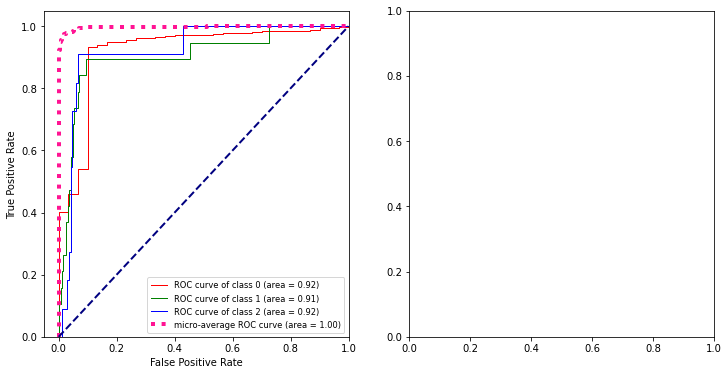

In [51]:
model = 'Logistic Regression'

clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, features, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, prc_lgra, roc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)

As can be seen, Logistic Regression performs very well in this analysis. mostly because classification is a simpler task than regression in this example. 

### 3 - 3 - 2 - Classification - Random Forest<a class="anchor" id="section_3_3_2"></a>


Best Parameters:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest 

Confusion Matrix:
[[1117    0    0]
 [  19    0    0]
 [  11    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1117
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        11

    accuracy                           0.97     

/home/peyman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/peyman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



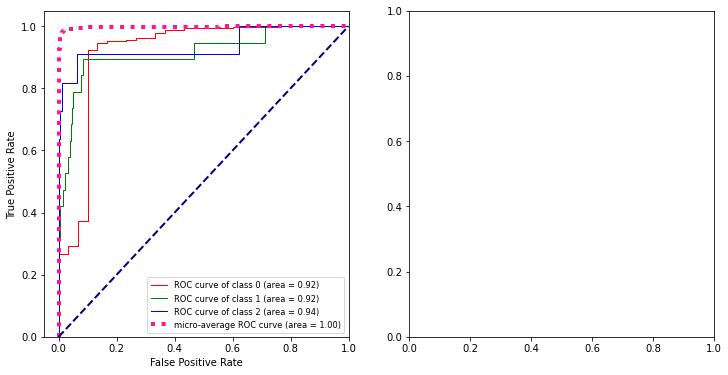

In [52]:
model = 'Random Forest'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfca, y_pred_rfca, y_score_rfca = multiclass_classify(model, clf_rfca, features, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, prc_rfca, roc_rfca = multiclass_metrics(model, y_test, y_pred_rfca, y_score_rfca, print_out=True, plot_out=True)


While not significantly better, but still returns a better model in comparison to Logistic regression.

### 3-3-3) Multiclass - Neural Network

Similar to the Neural Network approach for regression, multiclass classification can be performed. However, I did not do it here since the previous approach (logistic regression and random forest) returned satisfactory results. 

## 3 - 4 - Anomaly Detection <a class="anchor" id="section_3_4"></a>

Another way of tackling this problem is to do it from the standpoint of anomaly detection. There are several methods to deal with such problem include but not limited to KNN, OneClassSVM, HMM, LSTM. In the following, I use [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) and [LSTM]( https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/) for analysis of given time-series. 

### 3 - 4 - 1 - Anomaly Detertcion - OneClassSVM  <a class="anchor" id="section_3_4_1"></a>

This method is based on SVM and finds outliers/anomalies by generating a hypersphere, out of which corresponds to outliers (-1 below). 

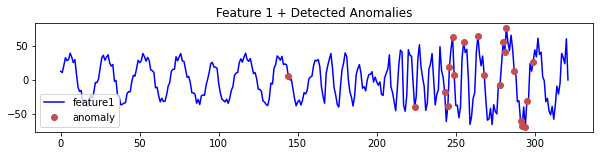

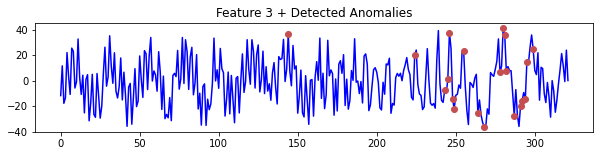

In [53]:
df = pd.read_csv('exampleco_data/machine_0.csv')
col_names = ['dateTime','feature1','feature2','feature3','feature4']
df.columns = col_names

df = remove_outliers(df, 3) # removing outlier
df = remove_tail(df, 0.1) # cut the unnecessary tail of time-series using the method mentioned before
df = df.reset_index(drop=True)
del df['dateTime']

model = OneClassSVM(nu=0.005, kernel="rbf", gamma='scale')
model.fit(df)
df['anomalySVM'] = np.array(model.predict(df))
a = df.loc[df['anomalySVM'] == -1, ['feature1','feature2','feature3','feature4']] #anomaly

plt.figure(figsize = (10, 2))
df['feature1'].plot(color = 'blue')
plt.plot(a.index, a['feature1'], 'ro', label= 'anomaly')
plt.title('Feature 1 + Detected Anomalies')
plt.legend()
plt.show()   

plt.figure(figsize = (10, 2))
df['feature3'].plot(color = 'blue')
plt.plot(a.index, a['feature3'], 'ro', label= 'anomaly')
plt.title('Feature 3 + Detected Anomalies')
# plt.legend()
plt.show() 

It seems that OneClassSVM is able to pick up anomolies especially during the faulty mode. However, it also reported some false positive during normal modes. 

### 4-2) LSTM

I don't show the results of LSTM since the output was not very satisfactory, maybe more data or a better feature engineering would help. I can provide my LSTM notebook if necessary. LSTM can also be used for a regression analysis to predict TTF (something similar to the NN approach above). 

# Conclusion   <a class="anchor" id="Conclusion"></a>

I'd like to thank you for the opportunity. I enjoyed working on this problem. 
Based on the above analysis, following conclusions can be made:


EDA:

1) Standard deviation has a higher relation with the TFF except for std2. This parameter shows a negative weight for TTF prediction, as shown by weight importance in the analysis section. 

2) Some features show nonlinear relation to TTF. 


Regression / Classification:

1) Regression analysis showed to be harder than clasification for the data set of this problem, mostly due to hyperparameter tunning especially for Neural Network. I used Ridge for its simplicity. Random Forest because it has been shown to be an effective method and also prevents overfitting because of its ensemble nature. And, Neural Network because it is able to learn very complex function/relations between features and target. Each has its own shortcommings as well. 

2) The performance was better from Ridge to Random Forest to NN, as expected. Note that NN needs more data to perfrom good compared to other methods. There is a chance that current model is overfitting (I tried to do validation in the learning process and put aside a test set). More work is needed to fully optimize the techniques used here. Please note that for regression, I included machine IDs as well which means that a machine related properties in included in the training process. I found regression results less satisfactory without the ID feature (as expected). 

3) I also tried Gradient Boosting (my experience shows it works good for time-series) but here there was not difference in output between Xgb and Random Forest. 

4) MultiClass classification performs significantly better than regression (somehow expected) in which it can alarm the maintenance team of possible failure within a given time-frame. This type of classification can be made even smarter by means of adding more classes (not just 3 used here). 

5) In the MultiClass classification analysis, Random Forest performed slightly better than Logistic Regression. By increasing the number of classes, the superiority of Random Forest will be even more obvious. I didn't show the results for NN for classification since the two methods used showed satisfactory performance.  


Anomaly Detection:

1) OneClassSVM was able to pick up a lot of anomalies during faulty mode of a machine. However, reporting false anomalies happen in some cases. I showed the results for machine 0, but I also checked other machines.

2) For LSTM, I tried to detect anomalies but the results were not as satisfactory as expected (not significantly better than OneClassSVM). Therefore, I didn't show the analysis here. 


Please note that a hyperparameter tunning is necessary for most of the above techniques which I've not been able to fully perform it. I did, however, try to do some trial & error to optimize parameters. Further improvement may be needed to improve the performance of each technique. Also, I tried to use a grid search for some of the methods. 

### References:  <a class="anchor" id="References"></a>

1) https://en.wikipedia.org/wiki/Anomaly_detection
2) https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/predictive-maintenance-playbook
3) https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
4) https://github.com/
5) http://eprints.whiterose.ac.uk/767/1/hodgevj4.pdf
6) https://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf
7) https://www.kaggle.com/